# TEPS Output Comparison

This notebook was copied from `20201216_teps2019`, and compares the annual average daily traffic (AADT) results of a recently complete TEPS run - the *proposed* - versus some historical AADT results - the *baseline*.

## Imports

In [1]:
%matplotlib inline
import sys
import pathlib
import configparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
import matplotlib.colors as colors
import matplotlib as mpl
from scipy import stats
import geopandas as gpd
import psycopg2
# The package's location relative to this Jupyter Notebook.
sys.path.append('../../')

Load your Postgres credentials using `ConfigParser`.

In [2]:
config = configparser.ConfigParser()
config.read(pathlib.Path.home().joinpath(".charlesconfig").as_posix());
postgres_settings = config['POSTGRES']

## Define File Paths

In addition to the AADT files, we'll also need the lengths of centreline segments, available in `{TEPS_FOLDER}/KCOUNT/RMsma_2km_pos/centreline_length.csv`.

In [3]:
path_baseline = "{YOUR BASELINE FILES}"
path_proposed = "{YOUR PROPOSED FILES}"

In [5]:
teps_path = "{YOUR TEPS PATH}"
teps_path = "/mnt/c/Users/czhu5/Documents/VolumeModel/TEPS-I-EEDrun/"

centreline_lengths = pd.read_csv(teps_path + "/KCOUNT/RMsma_2km_pos/centreline_length.csv")

## Visualizing Proposed vs. Baseline AADTs

One good way of comparing AADTs between the two datasets is to plot the AADT estimates for the years they have in common.

In [6]:
def read_csv(path, year):
    df = pd.read_csv(path + "final_aadt_{0}.csv".format(year), usecols=list(range(5)))
    df.columns = [x.strip() for x in df.columns.values]
    df.loc[df['LowerBound'] == 9999., 'LowerBound'] = np.nan
    df.loc[df['UpperBound'] == 9999., 'UpperBound'] = np.nan
    # LowerBound and UpperBound are symmetric.
    df['stdev'] = (df['UpperBound'] - df['aadt']) / stats.norm.ppf(0.975, loc=0, scale=1)
    return df


def x_dist(path1, path2, year):
    # See also https://www.sciencedirect.com/science/article/pii/S0741521402000307
    
    df1 = read_csv(path1, year).dropna()
    df2 = read_csv(path2, year).dropna()
    
    df = pd.merge(df1, df2, how='inner', on=('centreline_id', 'dir_bin'),
                  suffixes=('_1', '_2'))

    df['aadt_difference'] = df['aadt_1'].values - df['aadt_2'].values
    
    df['aadt_percent_difference'] = abs(df['aadt_difference']) / df['aadt_1']

    return df


def multiyear_deviation_diagnostic(path_1, path_2, xlabel, ylabel, year_range):
    year_end = year_range[1] + 1
    year_begin = year_range[0]
    n_rows = (year_end - year_begin) // 4 + (1 if (year_end - year_begin) % 4 else 0)

    fig1, axs1 = plt.subplots(n_rows, 4, figsize=(15, 4 * n_rows))
    fig1.subplots_adjust(left=0.1, right=0.92, bottom=0.1, top=0.925)

    fig2, axs2 = plt.subplots(n_rows, 4, figsize=(15, 4 * n_rows))
    fig2.subplots_adjust(left=0.1, right=0.92, bottom=0.1, top=0.925)

    for idx, year in enumerate(range(year_begin, year_end)):
        i = idx // 4
        j = idx % 4

        dft = x_dist(path_1, path_2, year)

        maxval = max([dft['aadt_1'].max(), dft['aadt_2'].max()])
        axs1[i, j].plot([0, maxval], [0, maxval], 'b--', lw=1)
        axs1[i, j].plot(dft['aadt_1'], dft['aadt_2'], 'ro', ms=1)
        
        axs1[i, j].set(xlim=[0, maxval], ylim=[0, maxval], aspect=1, title=str(year))
        axs1[i, j].axes.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
        axs1[i, j].xaxis.set_major_locator(mtk.MultipleLocator(2e4))
        axs1[i, j].yaxis.set_major_locator(mtk.MultipleLocator(2e4))

        axs2[i, j].plot(dft['aadt_1'], dft['aadt_percent_difference'], 'bo', ms=1)
        axs2[i, j].axes.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
        axs2[i, j].set(yscale='log', title=str(year), ylim=[1e-4, 1e1])

    fig1.text(0.5, 0.05, xlabel, ha='center', fontsize=14)
    fig1.text(0.05, 0.5, ylabel, va='center', rotation='vertical', fontsize=14)
    fig1.suptitle("{0} vs. {1} Values".format(ylabel, xlabel), fontsize=18)

    fig2.text(0.5, 0.05, xlabel, ha='center', fontsize=14)
    fig2.text(0.05, 0.5, 'Fractional Deviation', va='center', rotation='vertical', fontsize=14)
    fig2.suptitle("{0} vs. {1} Absolute Fractional Error".format(ylabel, xlabel), fontsize=18)

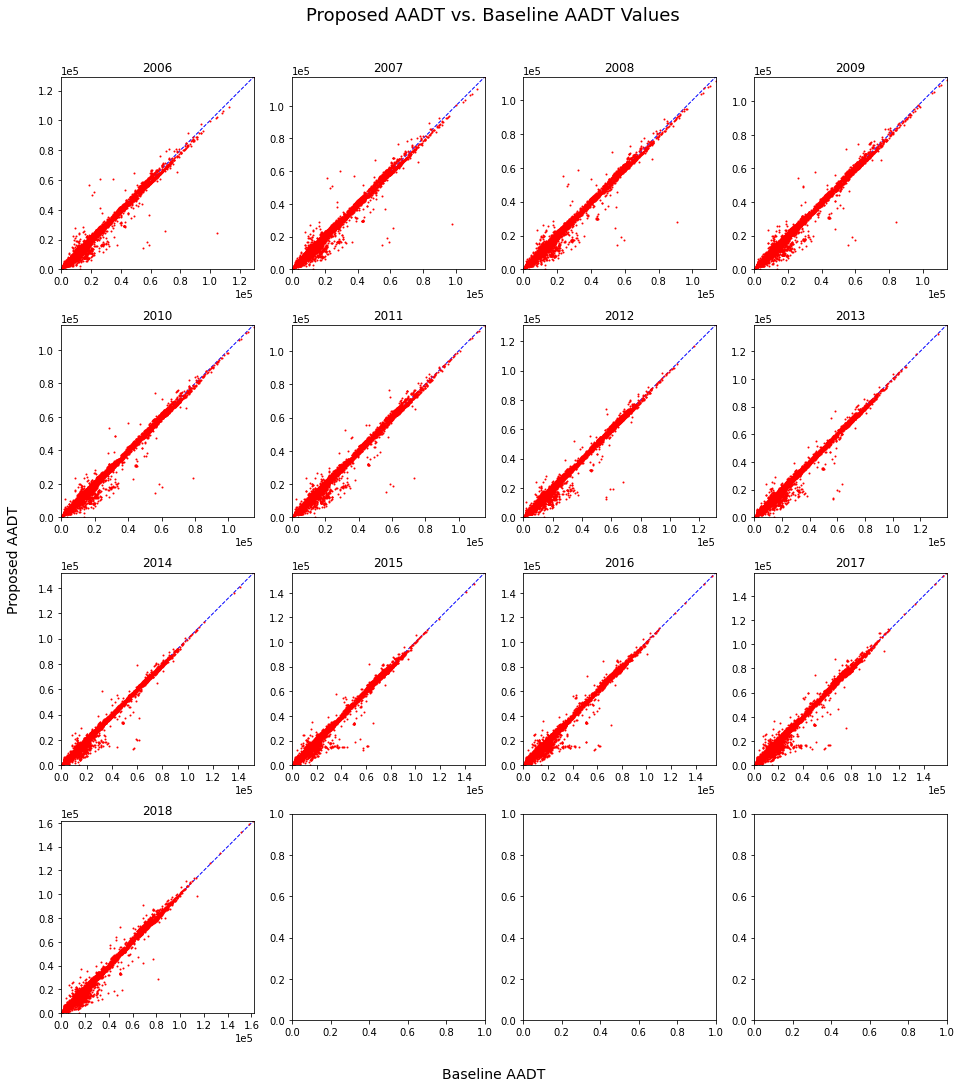

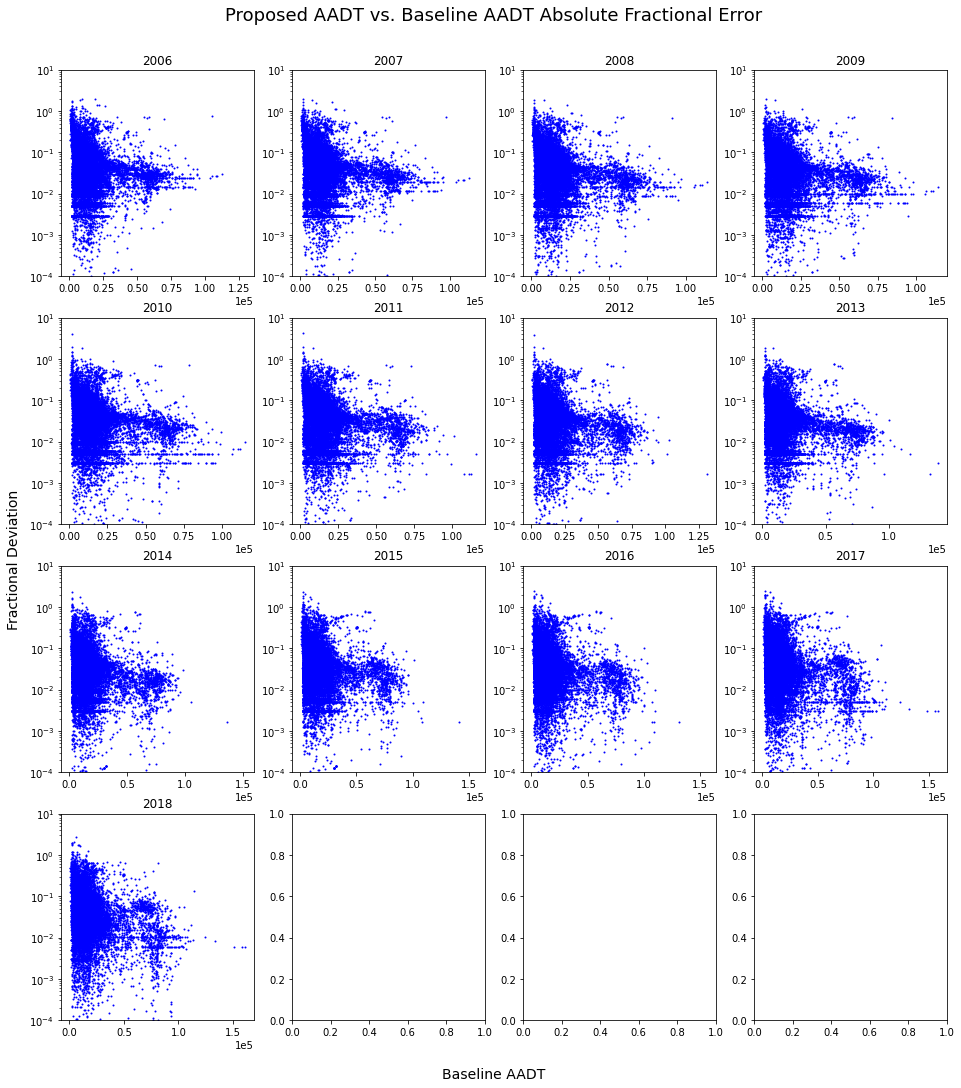

In [7]:
multiyear_deviation_diagnostic(path_baseline, path_proposed, "Baseline AADT", "Proposed AADT", (2006, 2018))

The top set of figures plots **proposed vs. baseline AADT**, with a dashed blue line indicating a 1-to-1 relationship. The bottom set of figures plots **fractional deviation**

$$
\frac{|\mathrm{AADT}_\mathrm{proposed} - \mathrm{AADT}_\mathrm{baseline}|}{\mathrm{AADT}_\mathrm{baseline}}
$$

**as a function of baseline AADT**. Both are ways of visualizing how much the proposed AADT differs from the baseline. In the proposed vs. baseline AADT plots, we see that most proposed AADTs track their baseline counterparts closely, but there are some outliers, particularly at smaller estimated AADTs. This is also seen in the fractional deviation plots - the fractional deviation is typically between 0.01 and 0.1 at AADTs approaching $10^5$ vehicles / day, but smaller AADTs see both smaller and larger relative deviations, with a handful of estimates having deviations in excess of 1.

There are two main reasons for why there can be differences between runs:
- The proposed run contains different permanent count stations (most likely more stations due to the inclusion of more recent years of data). Recall that TEPS takes information from all neighbouring years to make its estimates, and does so using both prior and *subsequent* years.
- The proposed run contains additional short-term counts (most likely more). These serve as the basis for estimating AADTs on arterial (using KCOUNT) and local roads (using LSVR), and so changing them will change predictions.
  - The majority of locations with no historical counts are on local, collector and minor arterial roads (all of which have lower AADTs), which may explain the higher fractional deviations we see at low baseline AADT.

## Baseline vs proposed map

We should also check that these errors are not geospatially clustered.  We can do this by plotting the fractional deviation on a map for a given year:

In [8]:
with psycopg2.connect(**postgres_settings) as db_con:
    # Read in data.
    sql_query = ("SELECT centreline_id, fcode_desc, geom, lon, lat "
                 "FROM prj_volume.tp_centreline_lonlat")
    ctrline_geoms = gpd.read_postgis(sql_query, db_con)
    ctrline_geoms['centreline_id'] = ctrline_geoms['centreline_id'].astype(int)
    ctrline_geoms.to_crs({'init': 'epsg:3347'}, inplace=True)
    ctrline_geoms['geom'] = ctrline_geoms.rotate(-28., origin=ctrline_geoms.unary_union.centroid)
    

def map_fractional_err(path_1, path_2, year, title, filename=None):
    dft = x_dist(path_1, path_2, year)
    dft = pd.merge(ctrline_geoms[['centreline_id', 'geom']],
                   dft[['centreline_id', 'aadt_percent_difference']],
                   how='inner', on='centreline_id')
    dft = gpd.GeoDataFrame(dft, crs={'init': 'epsg:3347'}, geometry='geom')
    
    fig = plt.figure(figsize=(16, 9))
    fig.patch.set_facecolor('#1c1c1c')
    ax = fig.add_axes([0., 0., 0.8, 1.])
    ax.axis('off')
    ax.set_title(title, fontsize=20, pad=50, color='w')
    # Not absolute minimum, for more color dynamics.
    im = dft.plot(column='aadt_percent_difference', ax=ax,
                  cmap='viridis', norm=colors.LogNorm(vmin=1e-2, vmax=1.))
    cbax = fig.add_axes([0.8, 0., 0.025, 1.])
    cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=mpl.cm.viridis,
                                    norm=colors.LogNorm(vmin=1e-2, vmax=1.),
                                    orientation='vertical')
    cb1.ax.tick_params(axis='both', which='both', labelsize=12, pad=15, length=10,
                       width=1.5, labelcolor='white', colors='white')
    cb1.ax.set_ylabel('Fractional AADT Error', fontsize=15, color='white')

    if filename is not None:
        # Output to QGIS to check local continuity of error estimates.
        dft.to_file(filename)

/home/czhu/pythonenv/bditto/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


/home/czhu/pythonenv/bditto/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


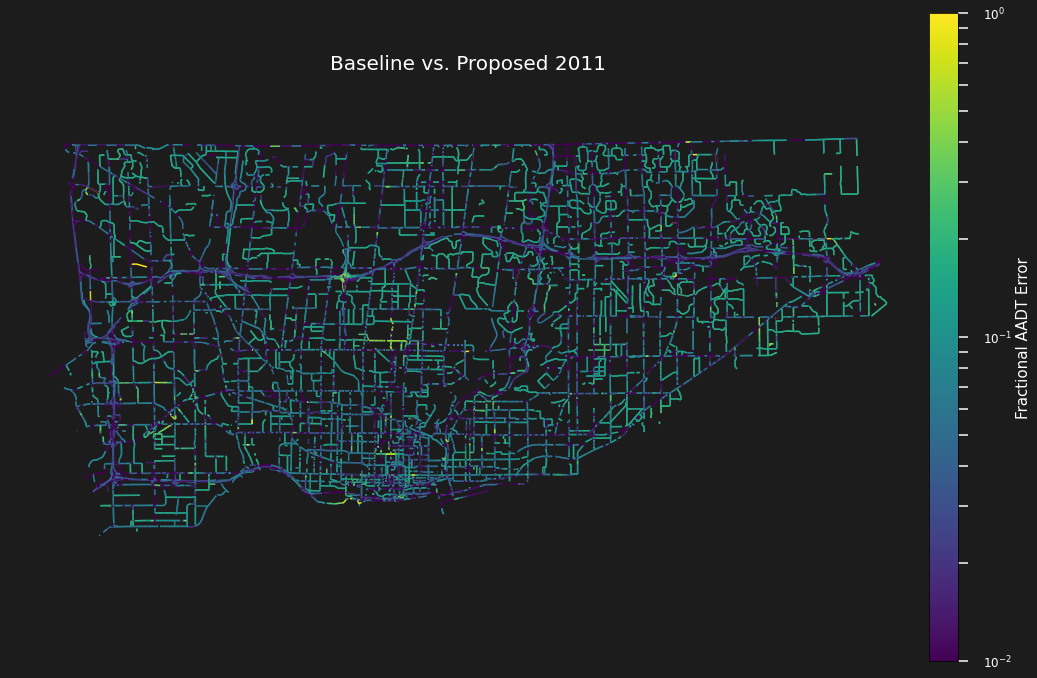

In [9]:
map_fractional_err(path_baseline, path_proposed, 2011, "Baseline vs. Proposed 2011")

It doesn't look like there's any kind of visible spatial clustering here - instead, it looks like overall there is 10-20% error for AADT on minor roads, and closer to a few percent error on major roads. (Of course, we should check every year to make sure this is true.)

## Comparing year-on-year citywide annually averaged daily VKT

We can estimate citywide VKT by multiplying AADT with road length, and summing up all segment-level VKTs.

In [10]:
def citywide_aavkt(path, year, getraw=False):
    df = read_csv(path, year)
    df = pd.merge(df[['centreline_id', 'dir_bin', 'aadt']],
                  centreline_lengths[['centreline', 'shape_leng_meter']],
                  how='left', left_on='centreline_id', right_on='centreline')
    df['aavkt'] = df['aadt'].values * df['shape_leng_meter'].values / 1000.
    if getraw:
        return df
    return df['aavkt'].sum()

In [11]:
baseline_aavkt = [citywide_aavkt(path_baseline, year) for year in range(2006, 2019)]
baseline_aavkt += [np.nan,]
proposed_aavkt = [citywide_aavkt(path_proposed, year) for year in range(2006, 2020)]
df_aavkt = pd.DataFrame({'baseline': baseline_aavkt, 'proposed': proposed_aavkt}, index=range(2006, 2020))

We've now calculated the citywide estimated VKTs.

In [12]:
df_aavkt

,baseline,proposed
2006,5.920086e+07,5.918671e+07
2007,6.001631e+07,6.008497e+07
2008,6.061885e+07,6.062783e+07
2009,6.219162e+07,6.199892e+07
2010,6.313190e+07,6.284900e+07
2011,6.402116e+07,6.393199e+07
2012,6.594074e+07,6.552766e+07
2013,6.792996e+07,6.760883e+07
2014,6.764927e+07,6.724798e+07
2015,6.862255e+07,6.857542e+07


On inspection, we see these are quite similar to one another, but we can also plot the absolute value and relative difference between the two:

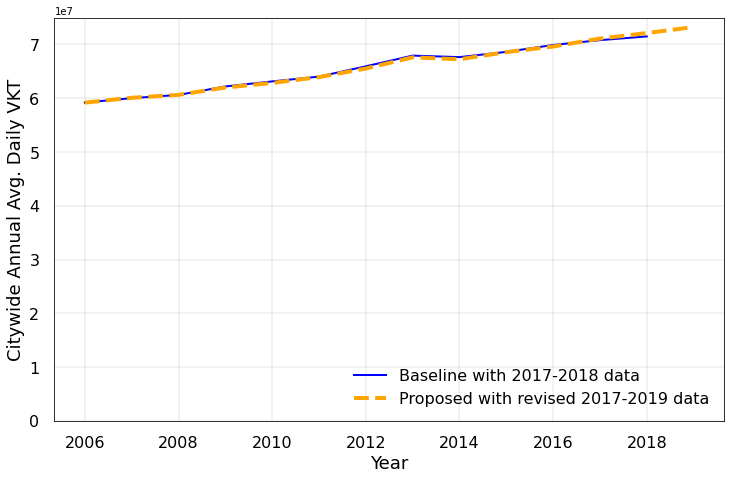

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(bottom=0.2, top=0.9)
df_aavkt.plot(ax=ax, y='baseline', label='Baseline with 2017-2018 data', lw=2, color='blue')
df_aavkt.plot(ax=ax, y='proposed', label='Proposed with revised 2017-2019 data', ls='--', lw=4, color='orange')
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.set_ylim([0, 7.5e7])
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Citywide Annual Avg. Daily VKT", fontsize=18)
ax.tick_params(axis='both', which='both', labelsize=16, length=0, pad=15)
ax.legend(loc=4, facecolor='white', frameon=False, fontsize=16);

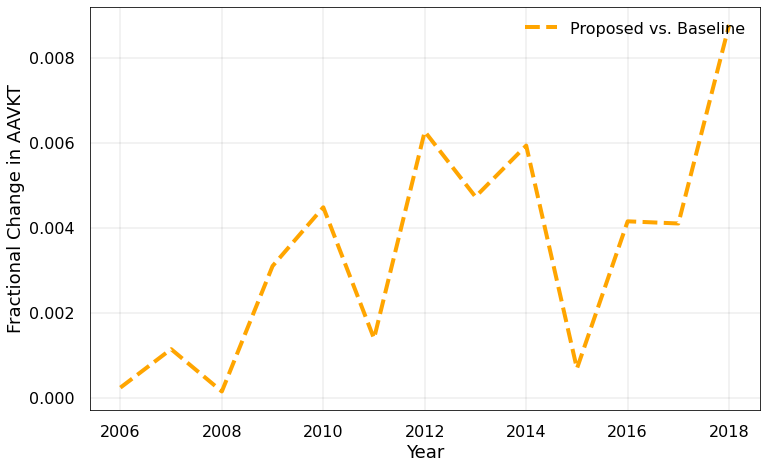

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.subplots_adjust(bottom=0.2, top=0.9)
ax.plot(df_aavkt.index.values, abs(df_aavkt['proposed'].values - df_aavkt['baseline'].values) / df_aavkt['baseline'].values,
        label='Proposed vs. Baseline', color='orange', lw=4, ls='--')
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Fractional Change in AAVKT", fontsize=18)
ax.tick_params(axis='both', which='both', labelsize=16, length=0, pad=15)
ax.legend(loc=1, facecolor='white', frameon=False, fontsize=16);